In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy.linalg as la
import scipy.sparse as sparse
from matplotlib import cm
import timeit
import numba
from numba import jit

In [2]:
#output settings
np.set_printoptions(precision=2)
# %matplotlib qt 

In [3]:
#Define analytical solution and source term
def u_analytical(x, y):

    uan = np.sin(np.pi*x)*np.sin(np.pi*y) + x

    return uan

def source(x, y):

    f = -2*np.pi**2*np.sin(np.pi*x)*np.sin(np.pi*y)

    return f

In [4]:
# @jit(nopython=True, parallel=False)
def numpy_jacobi(matrix, source, grid, init_guess=None, boundary=((0,0),(0,0)), tolerance=1.e-5, itermax=50):

    ''' 
    Solution of 2D Poisson equation using the jacobi iteration method. The solution in each grid point in the (k+1)th iteration is        calculated by the the values of the closest neighbours in the kth iteration. 
    We assume dirichlet boundary conditions (neumann will be added in the future). 

    ----------------------

    input
    matrix: (Nx*Ny)x(Nx*Ny) array. The matrix of the linear algebra problem. For the time being this parameter is                                                        redundant, we do not make use of it. 
    source: (Nx+1)x(Ny+1) array. The source term of the problem.
    grid: Tuple of the form (x, y). The grid where we solve the problem. It is provided as a meshgrid.
    init_guess: (Nx+1)x(Ny+1) array. The initial guess to start the iterative method. Default is None for which an array of ones is                                       assigned.
    boundary:tuple of two tuples of length 2. The set of Dirichlet boundary conditions in the form 
                                              ((u(x_I,y), u(x_F, y)), (u(x,y_I), u(x, y_F))). Default is zero.
    tolerance: float. The level of tolerance to set a stopping criterion. Default is 10^-5
    itermax: integer. The maximum number of iterations before returning a result if the desired tolerance has not been achieved.

    output
    u: (Nx+1)x(Ny+1) array. The solution of the problem.
    k: integer. The number of iteration that the solver performed.
    rel_diff: float. The ratio of the L2 norm of the difference of (k_final) and (k_final-1) iteration over the L2 norm of the                      (k_final-1) iteration.
    conv_hist: array. An array containg all the values of rel_diff to check the convergence history.
    '''

    #read the input
    M, f, u0, B, tol, kmax = matrix, source, init_guess, boundary, tolerance, itermax

    x, y = grid

    Nx = x.shape[1] - 1
    Ny = y.shape[0] - 1
    
    dx = (x[0, -1] - x[0, 0])/Nx
    dy = (y[-1, 0] - y[0, 0])/Ny
    
    #assign zero initial guess if non provided
    if init_guess is None:

        u0 = np.ones_like(f)

    #assign dirichlet boundary conditions
    u0[:, 0] = B[0][0]                               
    u0[:, -1] = B[0][1]
    u0[0, :] = B[1][0]
    u0[-1, :] = B[1][1]

    #initial values before the iteration loop starts
    u = u0
    k = 0
    rel_diff = tol +1
    conv_hist = []
    
    #iteration loop
    while k < kmax and rel_diff > tol:

        u_next = u.copy()

        #The jacobi method using numpy indexing
        u_next[1:-1, 1:-1] = ((u[:-2, 1:-1] + u[2:, 1:-1])*dx**2 + (u[1:-1, :-2] + u[1:-1, 2:])*dy**2 -
                              dx**2*dy**2*f[1:-1, 1:-1])/(2*(dx**2+dy**2))

        #stopping criterion
        
        rel_diff = la.norm(u_next - u)/la.norm(u)
        
        conv_hist.append(rel_diff)

        k += 1

        #update the value of the solution
        u = u_next

    return u, k, rel_diff, np.array(conv_hist)

In [5]:
def slow_jacobi(matrix, source, grid, init_guess = None, boundary=((0,0),(0,0)), tolerance = 1.e-5, itermax = 200):

    ''' 
    Solution of 2D Poisson equation using the jacobi iteration method. The solution in each grid point in the (k+1)th iteration is        calculated by the the values of the closest neighbours in the kth iteration. 
    We assume dirichlet boundary conditions (neumann will be added in the future). 

    ----------------------

    input
    matrix: (Nx*Ny)x(Nx*Ny) array. The matrix of the linear algebra problem. For the time being this parameter is                                                        redundant, we do not make use of it. 

    source: (Nx+1)x(Ny+1) array. The source term of the problem.
    grid: Tuple of the form (x, y). The grid where we solve the problem. It is provided as a meshgrid.
    init_guess: (Nx+1)x(Ny+1) array. The initial guess to start the iterative method. Default is None for which an array of ones is                                        assigned.
    boundary: tuple of two tuples of length 2. The set of Dirichlet boundary conditions in the form 
                                               ((u(x_I,y), u(x_F, y)), (u(x,y_I), u(x, y_F))). Default is zero.
    tolerance: float. The level of tolerance to set a stopping criterion. Default is 10^-5
    itermax: integer. The maximum number of iterations before returning a result if the desired tolerance has not been achieved.

    output
    u: (Nx+1)x(Ny+1) array. The solution of the problem.
    k: integer. The number of iteration that the solver performed.
    rel_diff: float. The ratio of the L2 norm of the difference of (k_final) and (k_final-1) iteration over the L2 norm of the                      (k_final-1) iteration.
    conv_hist: array. An array containg all the values of rel_diff to check the convergence history.
    '''
    #read the input
    M, f, u0, B, tol, kmax = matrix, source, init_guess, boundary, tolerance, itermax

    x, y = grid

    Nx = x.shape[1] - 1
    Ny = y.shape[0] - 1

    dx = (x[0, -1] - x[0, 0])/Nx
    dy = (y[-1, 0] - y[0, 0])/Ny

    #assign zero initial guess if non provided
    if init_guess is None:

        u0 = np.ones_like(f)
      

    #assign dirichlet boundary conditions
    u0[:, 0] = B[0][0]                               
    u0[:, -1] = B[0][1]
    u0[0, :] = B[1][0]
    u0[-1, :] = B[1][1]

    #initial values before the iteration loop starts
    u = u0
    rel_diff = tol + 1
    k = 0
    conv_hist = []

    #iteration loop using nested loops.
    while  k < kmax and rel_diff > tol:

        u_next = u.copy()

        for j in range(1, Ny):
            for i in range(1, Nx):
                
                u_next[j, i] = ((u[j, i-1] + u[j, i+1])*dy**2 + 
                                (u[j-1, i] + u[j+1, i])*dx**2 - f[j,i]*dx**2*dy**2)/(2*(dx**2+dy**2))

        
        rel_diff = la.norm(u_next - u)/la.norm(u)
        
        conv_hist.append(rel_diff)
        
        # L2norm = la.norm(u_temp - u, 2)
        # maxnorm = la.norm(u_temp - u, np.inf)

        # print(abs_diff, L2norm, maxnorm)


        u = u_next
        k += 1
        # print(u, '\n')
    return u, k, rel_diff, np.array(conv_hist)

In [6]:
#Set up the grid

Nx = 50                 #Number of grid points
Ny = 50

x_I, x_F = 0, 1         #start and end points           
y_I, y_F = 0, 1

X = np.linspace(x_I, x_F, Nx+1)         #1d grids in each dirrection        
Y = np.linspace(y_I, y_F, Ny+1)

x, y = np.meshgrid(X, Y)            #2d meshgrid

In [7]:
#Setup the parameters for the solver

f = source(x, y)                                #source term

u_guess = np.cos(np.pi*x)*np.cos(np.pi*y)       #initial guess

boundary = ((0,1), (X, X))                     #dirichlet boundary conditions


iterations = 20000
tolerance = 1.e-8

In [8]:
jitted_jacobi = jit(nopython=True)(slow_jacobi)
a, b, c, d = jitted_jacobi(np.eye(Nx), f, (x, y), init_guess=None, boundary=boundary,                                                                            tolerance=tolerance, itermax=1)

In [9]:
#Calculate the results, time them and print output

start = timeit.default_timer()

u_np, k_np, rel_diff_np, conv_hist_np = numpy_jacobi(np.eye(Nx), f, (x, y), init_guess=None, boundary=boundary, tolerance=tolerance,                                                       itermax=iterations)

elapsed_np = timeit.default_timer() - start

print('Numpy version \nNumber of iterations: {:} \nRelative difference: {:1.4E} \nElapsed time: {:1.2E}s'.format(k_np, rel_diff_np,                                                                                                                elapsed_np))
print('-'*50)

#------------------------------------------------

start = timeit.default_timer()

u_jit, k_jit, rel_diff_jit, conv_hist_jit = jitted_jacobi(np.eye(Nx), f, (x, y), init_guess=None, boundary=boundary,                                                                            tolerance=tolerance, itermax=iterations)

elapsed_jit = timeit.default_timer() - start

print('Jitted version \nNumber of iterations: {:} \nRelative difference: {:1.4E} \nElapsed time: {:1.2E}s'.format(k_jit, rel_diff_jit,                                                                                                                elapsed_jit))
print('-'*50)
#-----------------------------------------------

start = timeit.default_timer()

u_slow, k_slow, rel_diff_slow, conv_hist_slow = slow_jacobi(np.eye(Nx), f, (x, y), init_guess=u_guess, boundary=boundary,                                                                         tolerance=tolerance, itermax=iterations)

elapsed_slow = timeit.default_timer() - start

print('Slow version \nNumber of iterations: {:} \nRelative difference: {:1.4E} \nElapsed time: {:1.2E}s'.format(k_slow, rel_diff_slow,                                                                                                                elapsed_slow))

Numpy version 
Number of iterations: 4982 
Relative difference: 9.9893E-09 
Elapsed time: 3.64E-01s
--------------------------------------------------
Jitted version 
Number of iterations: 4982 
Relative difference: 9.9893E-09 
Elapsed time: 5.85E-02s
--------------------------------------------------
Slow version 
Number of iterations: 6122 
Relative difference: 9.9989E-09 
Elapsed time: 7.79E+01s


In [10]:
# time_np = %timeit -o numpy_jacobi(np.eye(Nx), f, (x, y), init_guess=u_guess, tolerance=tolerance,                                                                       itermax=iterations)

# time_jit = %timeit -o jitted_jacobi(np.eye(Nx), f, (x, y), init_guess=u_guess, tolerance=tolerance,                                                                       itermax=iterations)


In [11]:
# print(time_np.worst, time_jit.worst)

In [12]:
#Compare with analytical solution and verify that all versions produce the same results

u_an = u_analytical(x, y)

error_np = la.norm(u_np - u_an, 2)/la.norm(u_an, 2)
error_jit = la.norm(u_jit - u_an, 2)/la.norm(u_an, 2)
# error_slow = la.norm(u_slow - u_an, 2)/la.norm(u_an, 2)

print('Numpy version error: {:1.4E} \n'.format(error_np))
print('Jitted version error: {:1.4E} \n'.format(error_jit)) 
print('Slow version error {:1.4E} \n'.format(error_slow))                                                                                

Numpy version error: 1.5963E-04 

Jitted version error: 1.5963E-04 



NameError: name 'error_slow' is not defined

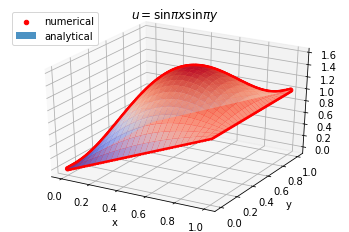

In [13]:
#Plot and compare the results

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

#plot just one of the versions
scat = ax.scatter(x, y, u_np, c = 'r', label = 'numerical', alpha = 1)
surf = ax.plot_surface(x, y, u_an, cmap = cm.coolwarm, label = 'analytical', alpha = 0.8)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('$u = \sin\pi x \sin\pi y + x$')

surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
ax.legend(loc = 2)
plt.show()

In [14]:
def fun():
    a = np.zeros(5)
    b = la.norm(a)
    c = 1/b
    return c
fun2 = jit(nopython=True)(fun)

In [15]:
fun()

inf

In [16]:
a = fun2
a

CPUDispatcher(<function fun at 0x7f87186638c0>)